In [14]:
import torch
import torch.nn as nn
import zipfile
import glob
import os
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from PIL import Image, UnidentifiedImageError,ImageFile
from CustomImageDataset import CustomImageDataset

In [15]:
folders = glob.glob('pianorolls/*')
print(folders)

['pianorolls/chopin', 'pianorolls/bach']


In [16]:
# train: test ratio. 0.2로 설정시 test set의 비율은 20%로 설정
test_size = 0.2

# train / test 셋의 파일을 나눕니다.
train_images = []
test_images = []

for folder in folders:
    label = os.path.basename(folder)
    files = sorted(glob.glob(folder + '/*'))

    # 각 Label별 이미지 데이터셋 셔플
    random.seed(42)
    random.shuffle(files)

    idx = int(len(files) * test_size)
    train = files[:-idx]
    test = files[-idx:]

    train_images.extend(train)
    test_images.extend(test)

# train, test 전체 이미지 셔플
random.shuffle(train_images)
random.shuffle(test_images)

# Class to Index 생성. {'chopin': 0, 'Bach': 1}
class_to_idx = {os.path.basename(f):idx for idx, f in enumerate(folders)}

# Label 생성
train_labels = [f.split('/')[-2] for f in train_images]
test_labels = [f.split('/')[-2] for f in test_images]

print('==='*10)
print(f'train images: {len(train_images)}')
print(f'train labels: {len(train_labels)}')
print(f'test images: {len(test_images)}')
print(f'test labels: {len(test_labels)}')

train images: 3872
train labels: 3872
test images: 967
test labels: 967


In [17]:
train_transform = transforms.Compose([
    transforms.ToTensor(), 
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # 이미지 정규화
])

test_transform = transforms.Compose([
    transforms.ToTensor(), 
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # 이미지 정규화
])

In [18]:
train_dataset = CustomImageDataset(train_images, train_labels, class_to_idx, train_transform)
test_dataset = CustomImageDataset(test_images, test_labels, class_to_idx, test_transform)

In [19]:
# train, test 데이터 로더 생성 => 모델 학습시 입력하는 데이터셋
train_loader = DataLoader(train_dataset, 
                          batch_size=128, 
                          shuffle=True,
                          num_workers=4
                         )

test_loader = DataLoader(test_dataset, 
                         batch_size=128, 
                         shuffle=True,
                         num_workers=4
                        )

In [20]:

images, labels = next(iter(train_loader))


In [21]:
images.shape

torch.Size([128, 3, 64, 64])

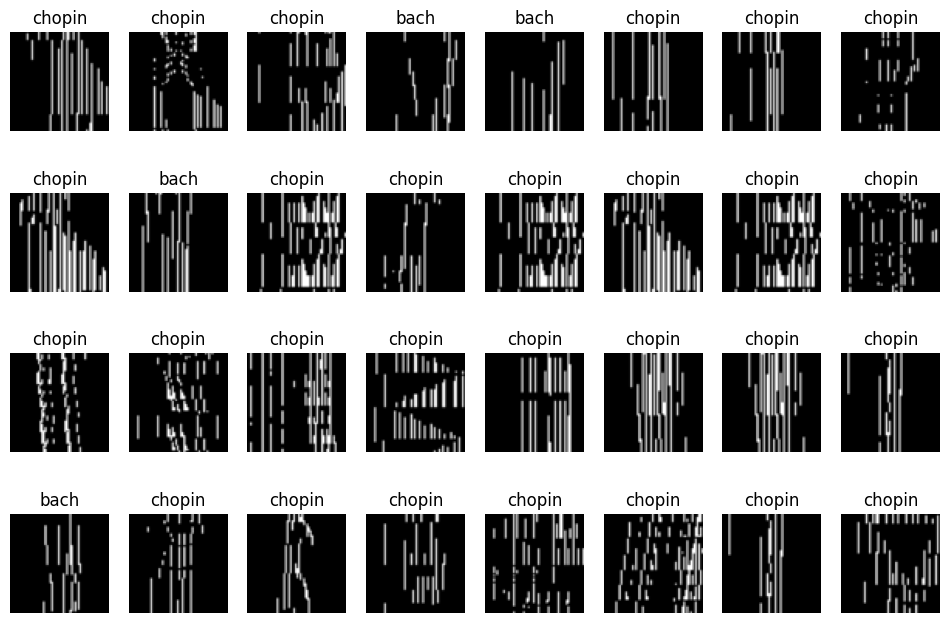

In [22]:
import matplotlib.pyplot as plt

# ImageFolder의 속성 값인 class_to_idx를 할당
labels_map = {v:k for k, v in train_dataset.class_to_idx.items()}

figure = plt.figure(figsize=(12, 8))
cols, rows = 8, 4

# 이미지를 출력합니다. RGB 이미지로 구성되어 있습니다.
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(torch.permute(img, (1, 2, 0)))
plt.show()

In [23]:
from model import resnet

model = resnet(num_classes=2)
print(model)

Resnet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (relu1): ReLU(inplace=True)
  (layer_2n): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (3): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

def train(epoch, global_steps):
    model.train()

    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        global_steps += 1
        outputs = model(inputs)
        print(outputs)
        print(targets)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    acc = 100 * correct / total
    print(f'train epoch: {epoch} [{batch_idx+1} / {len(train_loader)}] ')
    print(f'loss: {train_loss / (batch_idx + 1)} | acc: {acc}')

    return global_steps

In [25]:
def test(epoch, best_acc):
    model.eval()

    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            outputs = model(inputs)

            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100 * correct / total
    print(f'test epoch: {epoch} [{batch_idx+1} / {len(test_loader)}] ')
    print(f'loss: {test_loss / (batch_idx + 1)} | acc: {acc}')

    if (acc > best_acc):
        best_acc = acc
    
    return best_acc

In [26]:
best_acc = 0
epoch = 0
global_steps = 0

while True:
    epoch += 1
    global_steps = train(epoch, global_steps)
    best_acc = test(epoch, best_acc)
    print(f'best test acc: {best_acc}')

    if global_steps > 64000:
        break

tensor([[-18.8252,  -9.6344],
        [-21.4177, -17.1318],
        [-16.4691, -11.1216],
        [-11.2731,  -7.7126],
        [-14.8107, -12.5326],
        [ -9.3829,  -3.3601],
        [-11.5486,  -6.6679],
        [-15.0238,  -8.8354],
        [-11.8760,  -8.5511],
        [-14.0559, -12.5772],
        [ -8.9502,  -5.4393],
        [-15.6885,  -7.1978],
        [-18.4247,  -7.5642],
        [-12.4291,  -9.6027],
        [-13.8875,  -8.2841],
        [-15.6016,  -9.8898],
        [-13.3127,  -9.6898],
        [-16.5307,  -6.3027],
        [-11.3686,  -7.7233],
        [-10.7934,  -5.6936],
        [-22.6357, -13.2228],
        [ -3.7208,  -4.4954],
        [-13.5803, -10.1369],
        [-12.3460,  -5.2417],
        [-18.7192,  -8.4757],
        [-11.2074, -10.5471],
        [-21.3955, -11.7350],
        [-10.4298,   4.1018],
        [-17.5620,  -9.5971],
        [-18.3034,  -9.2982],
        [-17.7090, -12.4831],
        [-20.0456,  -8.6796],
        [-21.3375, -14.1781],
        [-